In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate

from Systems_Design_Preferendus.genetic_algorithm_pfm.genetic_algorithm_pfm.algorithm import GeneticAlgorithm

Set Weights for Different Objectives

In [2]:
# define constants
cons1 = 2.5   # costs per material
cons2 = 30  # material used per metre lenght
cons3 = 10  # material used per metre depth   
cons4 = 1.2  # ride lenght gained per metre length
cons5 = 0.5  # ride lenght gained per metre depth

w1 = 0.5  # weight for profit
w2 = 0.5  # weight for ride lenght

In [3]:
# Vectorized objective functions
def objective_function_1(x1, x2):
    """
    Cost function (vectorized).
    
    :param x1: reef length
    :param x2: reef depth below sea level 
    """
    return cons1 * cons2 * cons3 * np.array(x1) * (10 - np.array(x2))

def objective_function_2(x1, x2):
    """
    Ride-length function (vectorized).
    
    :param x1: reef length
    :param x2: reef depth below sea level 
    """
    return cons4 * np.array(x1) - cons5 * np.array(x2)


# Preference functions that convert raw objective values to 0-100 preference scores
def objective_p1(x1, x2):
    """Map cost -> preference score. Lower cost -> higher preference."""
    cost = objective_function_1(x1, x2)
    return pchip_interpolate([150000, 1000000, 2000000], [100, 50, 0], cost)

def objective_p2(x1, x2):
    """Map ride-length -> preference score. Higher ride length -> higher preference."""
    ride = objective_function_2(x1, x2)
    return pchip_interpolate([30, 150, 350], [0, 50, 100], ride)

def objective(variables):
    """Objective function that is fed to the GA. Expects variables with two columns (x1,x2)."""
    # ensure variables is a 2D numpy array
    vars_arr = np.atleast_2d(variables)
    x1 = vars_arr[:, 0]
    x2 = vars_arr[:, 1]

    # calculate the preference scores (vectorized)
    p_1 = objective_p1(x1, x2)
    p_2 = objective_p2(x1, x2)

    # return weights and preference arrays to the GA    
    return [w1, w2], [p_1, p_2]

Define Constraints and Bounds


In [4]:
def constraint_1(variables):
    """Constraint placeholder: return per-individual zeros (no violation).

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: 1-D array (length n) with constraint values; arr>0 means violation for 'ineq' constraints.
    """
    # decode variables if needed; here we simply indicate no violation for any individual
    n = variables.shape[0]
    return np.zeros(n)


def constraint_2(variables):
    """Constraint placeholder: return per-individual zeros (no violation).

    :param variables: ndarray of n-by-m, with n the population size of the GA and m the number of variables.
    :return: 1-D array (length n) with constraint values; arr>0 means violation for 'ineq' constraints.
    """
    n = variables.shape[0]
    return np.zeros(n)


# define list with constraints
cons = [['ineq', constraint_1], ['ineq', constraint_2]]

# set bounds for all variables
b1 = [30, 280]  # x1
b2 = [0.5, 3]  # x2
# b3 = (0, 260)  # x3
# b4 = (0, 260)  # x4
bounds = [b1, b2]

Graphical Output


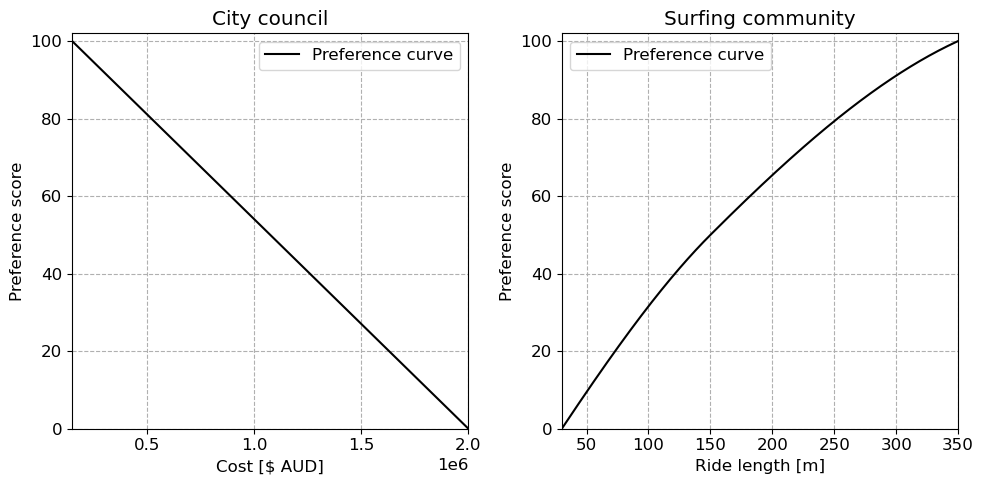

In [5]:
# create arrays for plotting continuous preference curves (use distinct names so we don't overwrite constants)
c1_vals = np.linspace(150000, 2000000, 300)
c2_vals = np.linspace(30, 350, 300)

# calculate the preference functions using the same knots as the preference mappings
p1_vals = pchip_interpolate([150000, 2000000], [100, 0], c1_vals)
p2_vals = pchip_interpolate([30, 150, 350], [0, 50, 100], c2_vals)

# create figure that plots all preference curves and the preference scores of the returned results of the GA
fig = plt.figure(figsize=((10,5)))

font1 = {'size':20}
font2 = {'size':15}

plt.rcParams['font.size'] = '12'
plt.rcParams['savefig.dpi'] = 300

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(c1_vals, p1_vals, label='Preference curve', color='black')
ax1.set_xlim((min(c1_vals), max(c1_vals)))
ax1.set_ylim((0, 102))
ax1.set_title('City council')
ax1.set_xlabel('Cost [$ AUD]')
ax1.set_ylabel('Preference score')
ax1.grid()
ax1.grid(linestyle = '--')

#fig = plt.figure()
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(c2_vals, p2_vals, label='Preference curve', color='black')
ax2.set_xlim((min(c2_vals), max(c2_vals)))
ax2.set_ylim((0, 102))
ax2.set_title('Surfing community')
ax2.set_xlabel('Ride length [m]')
ax2.set_ylabel('Preference score')
ax2.grid()
ax2.legend()
ax2.grid(linestyle = '--')

ax1.legend()
ax2.legend()
fig.tight_layout()

#Two lines to make our compiler able to draw:
#fig.savefig("/home/ruud/engineeringdesign.education/static/urbanplanningproblemfunctions.png")

Optimization

Now we have everything for the optimization, we can run it. For more information about the different options to configure the GA, see the docstring of GeneticAlgorithm (via help()) or chapter 4 of the reader. Once we have the results, we can make some figures. First, the resulting design variables are plotted into the solution space. Secondly, we can plot the preference functions together with the results of the optimizations.



Run GA with minmax
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            20.1499      33.7151          0            0.007        0           
1            19.7912      24.9352          0            0.161        0           
2            19.7912      21.7787          1            0.432        0           
3            19.7912      20.7373          2            0.453        0           
4            19.7912      20.6434          3            0.455        0           
5            19.7912      20.7387          4            0.452        0           
6            19.7912      20.605           5            0.457        0           
7            19.7912      20.5636          6            0.455        0           
8            19.7912      20.4676          7            0.465        0           
9            19.7912      20.554           8            0.456        0           
Stopped at gen 9
Exe

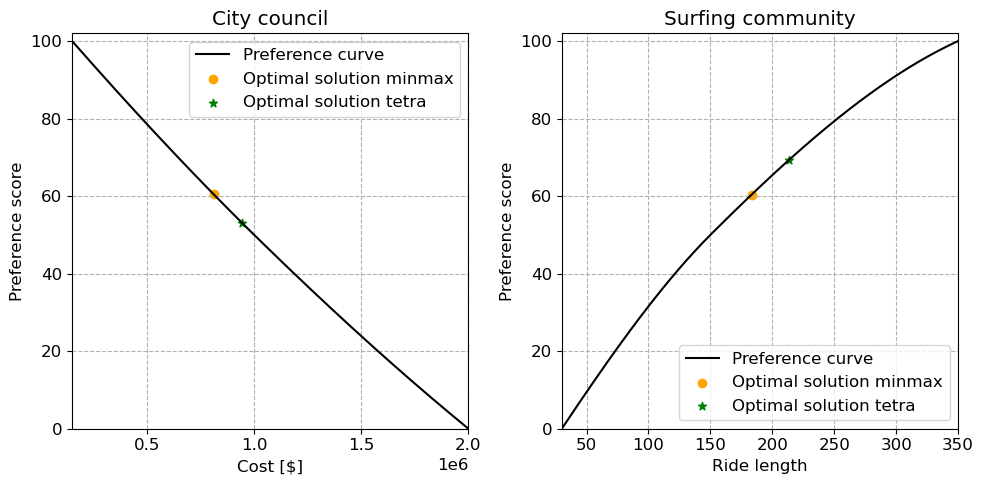

In [6]:
# Run the optimization with two paradigms (minmax and tetra)
paradigm = ['minmax', 'tetra']
marker = ['o', '*']
colours = ['orange','green']

# Prepare figure and axes
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for i, agg in enumerate(paradigm):
    # GA options
    options = {
        'n_bits': 8,
        'n_iter': 400,
        'n_pop': 500,
        'r_cross': 0.8,
        'max_stall': 8,
        'aggregation': agg,  # minmax or tetra
        'var_type': 'real'
    }

    # run the GA and get result
    print(f'Run GA with {agg}')
    ga = GeneticAlgorithm(objective=objective, constraints=cons, bounds=bounds, options=options)
    score, design_variables, _ = ga.run()

    # design_variables contains [x1, x2] for this notebook
    x1_opt = float(design_variables[0])
    x2_opt = float(design_variables[1])
    print(f'Optimal result for x1 = {round(x1_opt, 2)} and x2 = {round(x2_opt, 2)}')

    # compute raw objective values and preference scores for the optimal design
    c1_res = float(objective_function_1(x1_opt, x2_opt))
    p1_res = float(objective_p1(x1_opt, x2_opt))

    c2_res = float(objective_function_2(x1_opt, x2_opt))
    p2_res = float(objective_p2(x1_opt, x2_opt))

    # Debug prints
    print(f"c1_res: {c1_res}, p1_res: {p1_res}")
    print(f"c2_res: {c2_res}, p2_res: {p2_res}")

    # Plot preference curves once (they are defined over the raw objective axes)
    if i == 0:
        # cost preference curve (use the same knots as objective_p1)
        c1 = np.linspace(150000, 2000000, 300)
        p1_curve = pchip_interpolate([150000, 1000000, 2000000], [100, 50, 0], c1)
        ax1.plot(c1, p1_curve, label='Preference curve', color='black')
        ax1.set_xlim((min(c1), max(c1)))
        ax1.set_ylim((0, 102))
        ax1.set_title('City council')
        ax1.set_xlabel('Cost [$]')
        ax1.set_ylabel('Preference score')
        ax1.grid(linestyle='--')

        # ride-length preference curve (use the same knots as objective_p2)
        c2 = np.linspace(30, 350, 300)
        p2_curve = pchip_interpolate([30, 150, 350], [0, 50, 100], c2)
        ax2.plot(c2, p2_curve, label='Preference curve', color='black')
        ax2.set_xlim((min(c2), max(c2)))
        ax2.set_ylim((0, 102))
        ax2.set_title('Surfing community')
        ax2.set_xlabel('Ride length')
        ax2.set_ylabel('Preference score')
        ax2.grid(linestyle='--')

    # Scatter the GA result on the preference plots
    ax1.scatter(c1_res, p1_res, label='Optimal solution ' + agg, color=colours[i], marker=marker[i])
    ax2.scatter(c2_res, p2_res, label='Optimal solution ' + agg, color=colours[i], marker=marker[i])

# finalize plot
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()